# Fitting Censored and Truncated Data with LRMoE

## Introduction

In this notebook, we will demonstrate how to fit censored and truncated data with LRMoE. We start by simulating data from a two-component mixture, and then artificially impose data censoring and truncation. We then fit the data with LRMoE, and compare the results with the true parameters.

In [1]:
using DrWatson
@quickactivate "LRMoEjl Demo"

using CategoricalArrays, DataFrames, Distributions
using GLM, LRMoE, JLD2, PrettyTables, Random

# some helper functions are hidden in a separate source file
include(srcdir("2023-iCAS-Censor-Truncation-util.jl"))
using .cnesor_truncation_util_jl:
    plot_simulated_T_delay,
    plot_simulated_T_claim_T_delay,
    plot_observed_losses

## Data Simulation

Data censoring is common in insurance applications, e.g. the time of claims reporting delay. Let us consider a synthetic dataset that describes the distribution of reporting delay. We first simulate some covariates typically used in automobile insurance.

In [2]:
Random.seed!(7777)
sample_size = 10_000

X = DataFrame(
    intercept = fill(1.0, sample_size),
    sex = rand(Binomial(1, 0.50), sample_size),
    aged = rand(Uniform(20, 80), sample_size),
    agec = rand(Uniform(0, 10), sample_size),
    region = rand(Binomial(1, 0.50), sample_size)
)

pretty_table(first(X, 5), nosubheader=true)

┌───────────┬─────┬─────────┬──────────┬────────┐
│ intercept │ sex │    aged │     agec │ region │
├───────────┼─────┼─────────┼──────────┼────────┤
│       1.0 │   0 │ 44.1331 │   7.8814 │      1 │
│       1.0 │   1 │ 35.9979 │  4.29332 │      1 │
│       1.0 │   0 │ 54.0499 │ 0.698563 │      1 │
│       1.0 │   0 │ 47.4046 │  4.78275 │      1 │
│       1.0 │   1 │ 32.7516 │  1.62825 │      1 │
└───────────┴─────┴─────────┴──────────┴────────┘


We assume the claim reporting delay is generated from a two-component LRMoE model with the following parameters.

In [3]:
# logit regression coefficients
α = [-0.5 1.0 -0.05 0.1 1.25;
     0.0 0.0   0.0 0.0  0.0]
# expert functions
comp_dist = [LogNormalExpert(4.0, 0.3) InverseGaussianExpert(20, 20)];

Now we are ready to simulate the actual claim reporting delay `T_delay` and visualize its distribution.

In [4]:
T_delay = LRMoE.sim_dataset(α, X, comp_dist)
T_delay = vec(T_delay);

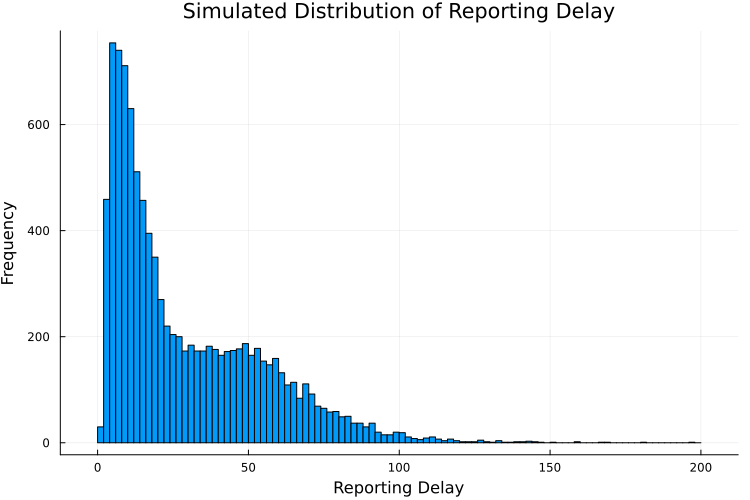

In [5]:
plot_simulated_T_delay(T_delay)

## Data Censoring

Even though we could simulate data from a true model, reporting delay is right-censored in practice, that is, for certain observations, we only know they are greater than a certain threshold (e.g. claims are reported beyond valuation date), but we do not know their exact values.

Let us assume accidents occur uniformly within a year, i.e. `T_accident` follows a uniform distribution from 0 to 365.

In [6]:
T_accident = rand(Uniform(0, 365), sample_size);

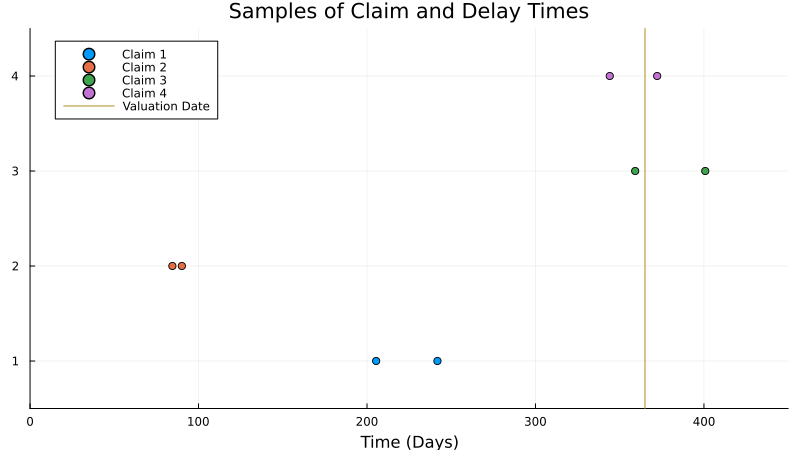

In [7]:
plot_simulated_T_claim_T_delay(T_accident, T_delay)

Let us also assume policy reserving is done at the end of year. With claims and reporting delay times simulated as above, we know `T_accident + T_delay` will be censored at 365, which is roughly 8% of the data.

In [8]:
println("Number of censored observations: $(sum((T_accident .+ T_delay) .> 365))")

Number of censored observations: 799


With data censoring, each observation of claim delay will be represented by a pair of values `(y_l, y_u)` to represent the reporting delay, which denote the lower and upper bounds of possible values.
* For exact values (i.e. no censoring), `y_l = y_u = T_delay`.
* For censoring, `y_l = 365 - T_claim`, and `y_u = Inf`.

In [9]:
# construct data frame for censoring
y_l = copy(T_delay)
y_u = copy(T_delay)
censor_idx = (T_accident .+ T_delay) .> 365
y_l[censor_idx] .= 365 .- T_accident[censor_idx]
y_u[censor_idx] .= Inf

# view constructed data
df_view = DataFrame(
    T_accident = T_accident,
    T_delay = T_delay,
    censored = censor_idx,
    y_l = y_l,
    y_u = y_u
)
pretty_table(df_view[[5, 10, 2500, 9998],:], nosubheader=true)

┌────────────┬─────────┬──────────┬─────────┬─────────┐
│ T_accident │ T_delay │ censored │     y_l │     y_u │
├────────────┼─────────┼──────────┼─────────┼─────────┤
│    205.432 │ 36.3824 │    false │ 36.3824 │ 36.3824 │
│    84.4814 │ 5.62915 │    false │ 5.62915 │ 5.62915 │
│    359.188 │ 41.5897 │     true │ 5.81169 │     Inf │
│    344.087 │ 28.1516 │     true │ 20.9133 │     Inf │
└────────────┴─────────┴──────────┴─────────┴─────────┘


The LRMoE package also requires two additional bounds `(t_l, t_u)` to indicate potential data truncation (see Data Truncation below). In this example of reporting delay, there is no truncation, so we set `t_l = 0` and `t_u = Inf`. 

In [10]:
t_l = fill(0.0, sample_size)
t_u = fill(Inf, sample_size)

# construct the complete dataframe
Y = DataFrame(t_l=t_l, y_l=y_l, y_u=y_u, t_u=t_u)
pretty_table(Y[[5, 10, 2500, 9998],:], nosubheader=true)

┌─────┬─────────┬─────────┬─────┐
│ t_l │     y_l │     y_u │ t_u │
├─────┼─────────┼─────────┼─────┤
│ 0.0 │ 36.3824 │ 36.3824 │ Inf │
│ 0.0 │ 5.62915 │ 5.62915 │ Inf │
│ 0.0 │ 5.81169 │     Inf │ Inf │
│ 0.0 │ 20.9133 │     Inf │ Inf │
└─────┴─────────┴─────────┴─────┘


## Fitting LRMoE with Censored Data

We will now fit the censored data with LRMoE, from a starting point reasonably close to the true parameters. The goal is to verify that LRMoE package can recover the true parameters in the presence of data censoring.

In [11]:
α_init = fill(0.0, 2, 5)
experts_init = [LogNormalExpert(3.5, 1.0) InverseGaussianExpert(25.0, 25.0)];

In [12]:
LRMoE_model = fit_LRMoE(Matrix(Y), X, α_init, experts_init;
    exact_Y=false, ϵ=0.01, ecm_iter_max=1000, print_steps=10)

┌ Info: Initial loglik: -40228.22015028288 (no penalty), -40228.22015028288 (with penalty)
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:22


┌ Info: Iteration 10, updating α: -39350.91851296972 ->  -39346.432668939786, ( + 0.011399591672700951 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:76
┌ Info: Iteration 10, updating model[1, 1]: -39346.432668939786 ->  -39300.34359480389, ( + 0.11713660174402318 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 10, updating model[1, 2]: -39300.34359480389 ->  -39293.31727770112, ( + 0.017878513163172665 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 20, updating α: -38891.79529623552 ->  -38890.97121239813, ( + 0.002118914365131523 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:76


┌ Info: Iteration 20, updating model[1, 1]: -38890.97121239813 ->  -38885.91147924357, ( + 0.013010045768527271 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 20, updating model[1, 2]: -38885.91147924357 ->  -38885.21963867514, ( + 0.0017791548201280542 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 30, updating α: -38862.328032565056 ->  -38861.95289610405, ( + 0.0009652959047968263 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:76


┌ Info: Iteration 30, updating model[1, 1]: -38861.95289610405 ->  -38861.70521496914, ( + 0.0006373357910594745 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 30, updating model[1, 2]: -38861.70521496914 ->  -38860.872617295856, ( + 0.0021424630460131285 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 40, updating α: -38852.49048418573 ->  -38852.332064220864, ( + 0.0004077472586439055 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:76


┌ Info: Iteration 40, updating model[1, 1]: -38852.332064220864 ->  -38852.26164490364, ( + 0.00018124862390271162 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 40, updating model[1, 2]: -38852.26164490364 ->  -38851.99838254219, ( + 0.0006775985497615184 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 50, updating α: -38849.71349311348 ->  -38849.67563087209, ( + 9.745822552477953e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:76


┌ Info: Iteration 50, updating model[1, 1]: -38849.67563087209 ->  -38849.66032635587, ( + 3.9394193044300186e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 50, updating model[1, 2]: -38849.66032635587 ->  -38849.60724522672, ( + 0.00013663215767607153 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 60, updating α: -38849.16037177153 ->  -38849.15348051021, ( + 1.7738507742804346e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:76


┌ Info: Iteration 60, updating model[1, 1]: -38849.15348051021 ->  -38849.15075785762, ( + 7.008267487743172e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 60, updating model[1, 2]: -38849.15075785762 ->  -38849.14183140914, ( + 2.2977203628879092e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


LRMoESTDFit(LRMoESTD([-0.3735545743036989 0.8857936001945748 … 0.0913580757763654 1.1487175664471398; 0.0 0.0 … 0.0 0.0], AnyExpert{LRMoE.NonNegative, LRMoE.NonZI, Distribution{Univariate, Continuous}}[LogNormalExpert{Float64}(4.005661751819819, 0.3071405608852865) InverseGaussianExpert{Float64}(18.871820235276413, 20.333099018911458)]), true, 64, -38849.093771291205, -38846.78619511297, 77711.57239022593, 77776.46545357372)

We see from below the true parameters are recovered reasonably well. The fitted LRMoE model for reporting delay can then be integrated into a general framework for claims reserving.

In [13]:
summary(LRMoE_model)

Model: LRMoE
Fitting converged after 64 iterations
Dimension of response: 1
Number of components: 2
Loglik: -38849.093771291205
Loglik (no penalty): -38846.78619511297
AIC: 77711.57239022593
BIC: 77776.46545357372
Fitted α:


[-0.3735545743036989 0.8857936001945748 -0.04670249038032605 0.0913580757763654 1.1487175664471398; 0.0 0.0 0.0 0.0 0.0]
Fitted component distributions:
AnyExpert{LRMoE.NonNegative, LRMoE.NonZI, Distribution{Univariate, Continuous}}[LogNormalExpert{Float64}(4.005661751819819, 0.3071405608852865) InverseGaussianExpert{Float64}(18.871820235276413, 20.333099018911458)]


In [14]:
α

2×5 Matrix{Float64}:
 -0.5  1.0  -0.05  0.1  1.25
  0.0  0.0   0.0   0.0  0.0

In [15]:
comp_dist

1×2 Matrix{AnyExpert{LRMoE.NonNegative, LRMoE.NonZI, Distribution{Univariate, Continuous}}}:
 LogNormalExpert{Float64}(4.0, 0.3)  …  InverseGaussianExpert{Float64}(20.0, 20.0)

## Data Truncation

Data truncation is also common in insurance applications, e.g. due to policy deductibles.
Let us simulate from the same LRMoE model, but assume the dataset now represents the distribution of incurred losses.

In [16]:
actual_loss = LRMoE.sim_dataset(α, X, comp_dist);

Assuming there is a policy deductible of 10, all losses below the deductible will not be observed by the insurer.
This is represented by setting `t_l = 10` and `t_u = Inf`, whereby the lower bound represents the level of left-truncation, i.e. policy deductible.

In [17]:
truncation_idx = actual_loss .< 10
println("Number of truncated observations: $(sum(truncation_idx))")

Number of truncated observations: 2774


The input data for fitting LRMoE can now be constructed, with `y_l = y_u = actual_loss` (since observed losses are exact), `t_l = 10`, and `t_u = Inf`. Afterwards, we can call the fitting function similarly as before.

In [26]:
t_l = fill(10.0, sample_size .- sum(truncation_idx))
y_l = actual_loss[.!truncation_idx]
y_u = actual_loss[.!truncation_idx]
t_u = fill(Inf, sample_size .- sum(truncation_idx))

# construct the complete dataframe
X_truncated = X[.!vec(truncation_idx), :]
Y_truncated = DataFrame(t_l=t_l, y_l=y_l, y_u=y_u, t_u=t_u)
pretty_table(Y[1:5,:], nosubheader=true)

┌─────┬─────────┬─────────┬─────┐
│ t_l │     y_l │     y_u │ t_u │
├─────┼─────────┼─────────┼─────┤
│ 0.0 │ 50.5435 │ 50.5435 │ Inf │
│ 0.0 │ 3.15423 │ 3.15423 │ Inf │
│ 0.0 │ 22.0824 │ 22.0824 │ Inf │
│ 0.0 │ 11.8929 │ 11.8929 │ Inf │
│ 0.0 │ 36.3824 │ 36.3824 │ Inf │
└─────┴─────────┴─────────┴─────┘


Note that losses below the deductible are dropped from the dataset, which can be observed from the following histogram.

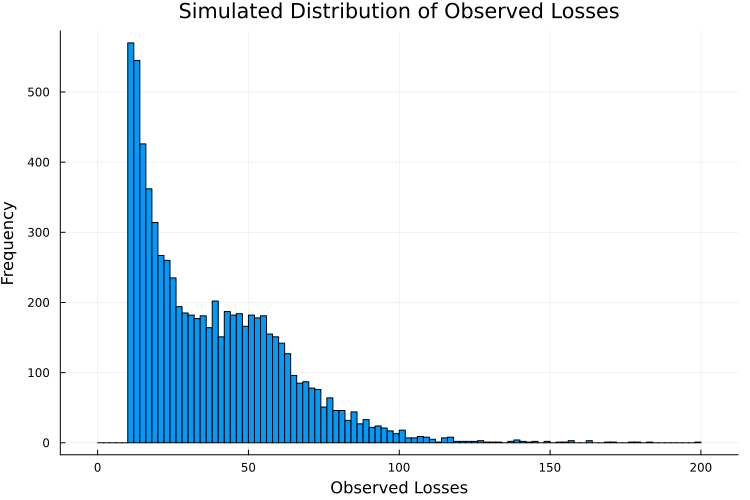

In [19]:
plot_observed_losses(y_l)

In [20]:
LRMoE_model_truncated = fit_LRMoE(Y_truncated, X_truncated, α_init, experts_init;
    exact_Y=false, ϵ=0.01, ecm_iter_max=1000, print_steps=10)

DimensionMismatch: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(10000), Base.OneTo(2)), b has dims (Base.OneTo(7226), Base.OneTo(2)), mismatch at 1

In general, the LRMoE package can handle various combinations of data censoring and truncation. For more details, please refer to the [documentation](https://actsci.utstat.utoronto.ca/LRMoE.jl/stable/).